<a href="https://colab.research.google.com/github/JMortonTan/oahu-jaxbill/blob/main/FML_DK_JT_BirdClef2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Test Google Colab Environment

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('You are using Google Colab Poor')
else:
  print('You are using Google Colab Pro')

Your runtime has 27.3 gigabytes of available RAM

You are using Google Colab Pro


# Introduction

Jax is a powerful python package developed by Google which houses a suite of functions that allow for hardware agnostic accelerations without needing to redefine functions or customize code.

With it, we are able to perform complex computations such as autodiff, JIT compilation, vectorization, parallelizations, and other transformation functions on hardware such as the CPU, GPU or TPU depending on what is available.

This has a host of benefits for research and the field of data science.

From making codebase more portable to collaborate one, it also makes conclusions easier to share, faster to process, and much cheaper in resources to achieve.

# Mission

In this example, we will utilize the JAX and FLAX libraries to demonstrate the rapid ability to load data from the CPU into GPU/TPU memory, as well as implementing the VGG-19 convolutional neural network to train it to understand birdsongs.

We will demonstrate these techniques through the real-world dataset provided by Cornell Lab of Ornithology and the BirdCLEF 2022 Kaggle competition.

https://www.kaggle.com/competitions/birdclef-2022/overview


# Import Libraries and Define Names

In [ ]:
!pip install -q flax

     |████████████████████████████████| 184 kB 31.6 MB/s 
     |████████████████████████████████| 140 kB 82.8 MB/s 
     |████████████████████████████████| 72 kB 500 kB/s 


In [ ]:
# Importing all the libraries necessary for the project
import os
import sys
import time
import math
import random
import librosa
import librosa.display #Explicit import due to optional dependency to matplotlib
import IPython.display as ipd
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.init as init
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from torch.utils.data import Dataset, random_split, DataLoader
import gc
from tqdm import tqdm, tqdm_notebook; tqdm.pandas()
import jax
import torchvision
import optax
import flax.linen as nn
import jax.nn
import jax.numpy as jnp
from flax import linen as nn
from tensorflow.keras.utils import to_categorical
seed = 1234
np.random.seed(seed)
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
warnings.filterwarnings("ignore")
from torchvision import transforms
import torch
from typing import Any
import functools
from flax.training import train_state
# to suppress warnings caused by cuda version
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# JAX TPU/GPU Diagnostics

Note:

In Google Colab, GPU is more often available.
Kaggle notebooks do not yet support GPU, but instead offer TPU.

The following code is to help configure whether or not TPU or GPU is available.

Because our class submission is made on Google Colab, the resulting configuration uses GPU when Google cloud services allow.

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
    tpu = None
    
if tpu:
    import requests
    if 'TPU_DRIVER_MODE' not in globals():
        url = 'http:' + os.environ['TPU_NAME'].split(':')[1] + ':8475/requestversion/tpu_driver_nightly'
        resp = requests.post(url)
        TPU_DRIVER_MODE = 1
    from jax.config import config
    config.FLAGS.jax_xla_backend = "tpu_driver"
    config.FLAGS.jax_backend_target = os.environ['TPU_NAME']
    print('Registered TPU:', config.FLAGS.jax_backend_target)

else:
    print('No TPU detected.')

No TPU detected.


In [ ]:
# List all the available devices
jax.devices()

[GpuDevice(id=0, process_index=0)]

# Fetch Credentials and Prepare Kaggle Materials

In [ ]:
!wget https://raw.githubusercontent.com/miknad2319/kaggle-credentials/main/kaggle.json
!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -q birdclef-2022 -p /kaggle/working


--2022-04-25 01:04:23--  https://raw.githubusercontent.com/miknad2319/kaggle-credentials/main/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62 [text/plain]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      62  --.-KB/s    in 0s      

2022-04-25 01:04:24 (2.93 MB/s) - ‘kaggle.json’ saved [62/62]



In [ ]:
!chmod 600 /kaggle/working/birdclef-2022.zip
!mkdir /kaggle/working/data
!mv /kaggle/working/birdclef-2022.zip /kaggle/working/data

In [ ]:
!unzip -q /kaggle/working/data/birdclef-2022.zip -d /kaggle/working/data/

# Define Training Data

In [ ]:
ROOT = "/kaggle/working/data"
os.listdir(ROOT)

['birdclef-2022.zip',
 'sample_submission.csv',
 'train_metadata.csv',
 'scored_birds.json',
 'test_soundscapes',
 'test.csv',
 'train_audio',
 'eBird_Taxonomy_v2021.csv']

In [ ]:
df = pd.read_csv(os.path.join(ROOT, 'train_metadata.csv'))[['primary_label', 'filename', 'time']]
df['path'] = ROOT+'/train_audio/' + df['filename']
df.head()

primary_label              filename   time  \
0       afrsil1  afrsil1/XC125458.ogg  08:00   
1       afrsil1  afrsil1/XC175522.ogg  08:30   
2       afrsil1  afrsil1/XC177993.ogg  11:30   
3       afrsil1  afrsil1/XC205893.ogg  11:00   
4       afrsil1  afrsil1/XC207431.ogg  16:30   

                                                path  
0  /kaggle/working/data/train_audio/afrsil1/XC125...  
1  /kaggle/working/data/train_audio/afrsil1/XC175...  
2  /kaggle/working/data/train_audio/afrsil1/XC177...  
3  /kaggle/working/data/train_audio/afrsil1/XC205...  
4  /kaggle/working/data/train_audio/afrsil1/XC207...

In [ ]:
#Sample 5 birds
classes = set(random.sample(df['primary_label'].unique().tolist(), 5)) 
print(classes)

ValueError: ignored

In [ ]:
df = df[df.primary_label.apply(lambda x: x in classes)].reset_index(drop=True)
keys = set(df.primary_label)
values = np.arange(0, len(keys))
code_dict = dict(zip(sorted(keys), values))
df['label'] = df['primary_label'].apply(lambda x: code_dict[x])
df.head()

primary_label             filename   time  \
0        bkbplo  bkbplo/XC563506.ogg  05:00   
1        bkbplo  bkbplo/XC526502.ogg  09:00   
2        bkbplo  bkbplo/XC484715.ogg  22:49   
3        bkbplo  bkbplo/XC615632.ogg  13:05   
4        bkbplo  bkbplo/XC333387.ogg  07:59   

                                                path  label  
0  /kaggle/working/data/train_audio/bkbplo/XC5635...      1  
1  /kaggle/working/data/train_audio/bkbplo/XC5265...      1  
2  /kaggle/working/data/train_audio/bkbplo/XC4847...      1  
3  /kaggle/working/data/train_audio/bkbplo/XC6156...      1  
4  /kaggle/working/data/train_audio/bkbplo/XC3333...      1

# Data Pre-Processing

Seed code for result reproduction:

In [ ]:
# seeding function for reproducibility
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
SEED = 42
FRAC = 0.2     # Validation fraction
SR = 44100     # sampling rate
MAXLEN= 60    # seconds
N_MELS = 128

seed_everything(SEED)
device = torch.device('cpu')

In [ ]:
#Define a function for playing .ogg files
def print_plot_play(x, Fs, text=''):
    ipd.display(ipd.Audio(data=x, rate=Fs))


A mel spectrogram is a specific type of spectrogram that specifically converts audio and signals into a spectrogram on the mel scale.

Why the mel scale some might ask? Frequency changes on the linear scale are not perceptable to human ears.  That is.. humans do not percieve sound in a linear fashion to the change in frequency.

Humans percieve sound on the mel scale.  In order to better understand sound on a visual chart, we must convert our spectrographs to be displayed in the mel spectrograph format.

The following is the mel-scaled  spectrogram of a House Sparrow song located at
/kaggle/working/data/train_audio/houspa/XC121738.ogg

![House Sparrow](https://upload.wikimedia.org/wikipedia/commons/6/6e/Passer_domesticus_male_%2815%29.jpg)

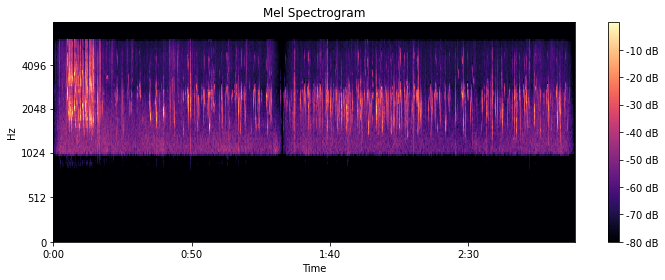

In [ ]:
path = "/kaggle/working/data/train_audio/houspa/XC121738.ogg"
audio, _ = librosa.load(path, sr=SR)

plt.figure(figsize=(10,4))
mels = librosa.feature.melspectrogram(y=audio, sr=SR,n_mels=N_MELS, hop_length = 347,n_fft = N_MELS *20,fmin = 20, fmax = SR//2)
librosa.display.specshow(librosa.power_to_db(mels,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()

fn_mp3 = os.path.join('..', 'data', 'B', '/kaggle/working/data/train_audio/houspa/XC121738.ogg')
x, Fs = librosa.load(fn_mp3, sr=None)
print_plot_play(x=x, Fs=Fs, text='MP3 file: ')

Here is another example of mel-scaled spectrogram containin the call of a Hawaiian Osprey.
/kaggle/working/data/train_audio/osprey/XC109037.ogg
![Hawaiian Osprey](https://i.ytimg.com/vi/C4M7QZuUS7o/maxresdefault.jpg)

In [ ]:
path="/kaggle/working/data/train_audio/osprey/XC109037.ogg"
audio, _ = librosa.load(path, sr=SR)

plt.figure(figsize=(10,4))
mels = librosa.feature.melspectrogram(y=audio, sr=SR,n_mels=N_MELS, hop_length = 347,n_fft = N_MELS *20,fmin = 20, fmax = SR//2)
librosa.display.specshow(librosa.power_to_db(mels,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()

fn_mp3 = os.path.join('..', 'data', 'B', '/kaggle/working/data/train_audio/osprey/XC109037.ogg')
x, Fs = librosa.load(fn_mp3, sr=None)
print_plot_play(x=x, Fs=Fs, text='MP3 file: ')

Using the Pytorch datasets and dataloaders classes, develop custom dataset class with functions pertaining to bird audio.

In [ ]:
class BirdSoundDataset(Dataset):
    """Bird Sound dataset."""

    def __init__(self, df, transform = None):
        """
        Args:
            df (pd.DataFrame): must have ['path', 'label'] columns
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    
    def loadMP3(self, path, duration):
        """
        Args:
            path: path of the audio file 
        Returns:
            mels: Melspectrogram of the given audio file 
        """
        try:
            duration=5
            samples = SR* duration
            audio, _ = librosa.load(path, sr=SR)
            
            if 0 < len(audio):
                audio, _ = librosa.effects.trim(audio)
            if len(audio) > samples: # long enough
                audio = audio[0:0+samples]
            else: # pad blank
                padding = samples - len(audio)
                offset = padding // 2
                y = np.pad(audio, (offset, samples - len(audio) - offset), 'constant')

            mels = librosa.feature.melspectrogram(y=audio, sr=SR,n_mels=N_MELS, hop_length = 347,n_fft = N_MELS *20,fmin = 20, fmax = SR//2)
            mels = librosa.power_to_db(mels).astype(np.float32)
            mels = mels.transpose()
            eps = 0.001
            if np.std(mels) != 0:
                mels = (mels - np.mean(mels)) / np.std(mels)
            else:
                mels = (mels - np.mean(mels)) / eps
            return mels
            
        except Exception as e:
            print("Error encountered while parsing file: ", path, e)
            mels = np.zeros((N_MELS, MAXLEN*SR//347), dtype=np.float32)
            return mels
            

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        path = self.df['path'].iloc[idx]
    
        duration=5
        if os.path.exists("./"+path.split('/')[-1]+".npy"):
            mels = np.load("./"+path.split('/')[-1]+".npy")
        else:
            
            mels = self.loadMP3(path, duration)
            np.save("./"+path.split('/')[-1]+".npy", mels)
        label  = self.df['label'].iloc[idx]
        mels = np.resize(mels,(636,128,1))
        return mels, label

Split train and validation sets

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
train_len = int(len(df) * (1-FRAC))
train_df = df.iloc[:train_len]
valid_df = df.iloc[train_len:]
train_df.shape, valid_df.shape

((244, 5), (61, 5))

# Begin Dataloading

In [ ]:
# prepare data loaders 
#NUM_TPUS = jax.device_count()
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(BirdSoundDataset(train_df),
                                           batch_size=BATCH_SIZE, 
                                           num_workers=0, 
                                           shuffle=True, 
                                           drop_last = True)

valid_loader = torch.utils.data.DataLoader(BirdSoundDataset(valid_df), 
                                           batch_size=BATCH_SIZE, 
                                           num_workers=0, 
                                           shuffle=True, 
                                           drop_last = True)

len(train_loader), len(valid_loader)

(7, 1)

In [ ]:
train_df.head()


primary_label             filename   time  \
0        bkbplo  bkbplo/XC595047.ogg  22:14   
1        bkbplo  bkbplo/XC433984.ogg  22:00   
2        bkbplo  bkbplo/XC603556.ogg  21:39   
3        bkbplo  bkbplo/XC589944.ogg  18:00   
4        bkbplo  bkbplo/XC569299.ogg  02:00   

                                                path  label  
0  /kaggle/working/data/train_audio/bkbplo/XC5950...      1  
1  /kaggle/working/data/train_audio/bkbplo/XC4339...      1  
2  /kaggle/working/data/train_audio/bkbplo/XC6035...      1  
3  /kaggle/working/data/train_audio/bkbplo/XC5899...      1  
4  /kaggle/working/data/train_audio/bkbplo/XC5692...      1

In [ ]:
(image_batch, label_batch) = next(iter(train_loader))
print(image_batch.shape)
print(label_batch.shape)

Batching/shrading data.
This technique allows data from CPU RAM to be read into the GPU/TPU to create SharddedDeviceArrays for JAX

In [ ]:
NUM_TPUS = jax.device_count()

def copy_dataset_to_devices(dataset, devices, num_reps=1):
    sharded_images = []
    sharded_labels = []
    for _ in range(num_reps):
        for image_batch, label_batch in tqdm(dataset, ncols=100):
            image_batch = image_batch.detach().cpu().numpy()
            image_batches = np.split(image_batch, NUM_TPUS, axis = 0)
            sharded_device_images = jax.device_put_sharded(image_batches, devices)
            sharded_images.append(sharded_device_images)

            label_batch = label_batch.detach().cpu().numpy()
            label_batches = np.split(label_batch, NUM_TPUS, axis = 0)
            sharded_device_labels = jax.device_put_sharded(label_batches, devices)
            sharded_labels.append(sharded_device_labels)

    return sharded_images, sharded_labels

devices = jax.local_devices()
sharded_training_images, sharded_training_labels = copy_dataset_to_devices(train_loader, devices, num_reps=10)

# Model Development

FLAX Linen allows us to define a model architecture.
The VGG19 network is arbitrarily selected.

In [ ]:
NUM_CLASSES = 5 #CHOSEN FROM THE 10 SAMPLE BIRDS RANDOMLY SELECTED ABOVE 
class VGG19(nn.Module):
    @nn.compact
    def __call__(self, x, training):
        x = self._stack(x, 64, training)
        x = self._stack(x, 64, training)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
    
        x = self._stack(x, 128, training)
        x = self._stack(x, 128, training)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = self._stack(x, 256, training)
        x = self._stack(x, 256, training)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))    

        x = self._stack(x, 512, training)
        x = self._stack(x, 512, training)
        x = self._stack(x, 512, training)
        x = self._stack(x, 512, training)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))    
    
        x = self._stack(x, 512, training)
        x = self._stack(x, 512, training)
        x = self._stack(x, 512, training)
        x = self._stack(x, 512, training)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))  

        x = x.reshape((x.shape[0], -1))

        x = nn.Dense(features=4096)(x)
        x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.relu(x)
        x = nn.Dropout(0.5, deterministic=not training)(x)

        x = nn.Dense(features=4096)(x)
        x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.relu(x)
        x = nn.Dropout(0.5, deterministic=not training)(x)
    
        x = nn.Dense(features=NUM_CLASSES)(x)
        return x
  
    @staticmethod
    def _stack(x, features, training, dropout=None):
        x = nn.Conv(features=features, kernel_size=(3, 3), padding='SAME')(x)
        x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.relu(x)
        return x

Define Training Functions

In [ ]:
def average_metrics(metrics):
    '''
    Takes the list of dictionaries of the form k: v, and returns a dictionary
     of the form k: (average of the v).
    '''
    return {k: np.mean([metric[k] for metric in metrics])
        for k in metrics[0]}

def train(initial_network_state, num_epochs):
    '''
    Training the model from the given state, returns the state along with the training accuracies
    '''
    training_accuracies = []
    state = initial_network_state
    for i in range(num_epochs):
        batch_metrics = []
        for (image_batch, label_batch) in tqdm(zip(sharded_training_images,
                                               sharded_training_labels),
                                           total=len(sharded_training_images),
                                           ncols=100):
            state, metrics = train_batch(state, image_batch, label_batch)
            batch_metrics.append(metrics)
        train_metrics = average_metrics(batch_metrics)
        print(f'Epoch {i+1} done.', flush=True)
        print(f'  Loss: {train_metrics["loss"]:.4f}, '
          + f'accuracy: {train_metrics["accuracy"]:.4f}', flush=True)
        training_accuracies.append(train_metrics["accuracy"])
    return state, training_accuracies

Implement defined model with fuctions.

In [ ]:
class VGGState(train_state.TrainState):
    rng: Any
    batch_stats: Any
  
    @classmethod
    def create(cls, apply_fn, params, tx, rng, batch_stats):
        opt_state = tx.init(params)
        state = cls(0, apply_fn, params, tx, opt_state, rng, batch_stats)
        return state
  
    @classmethod
    def update_rng(cls, state, rng):
        return VGGState.create(state.apply_fn, state.params, state.tx, rng,
                           state.batch_stats)
  
    @classmethod
    def update_batch_stats(cls, state, batch_stats):
        return VGGState.create(state.apply_fn, state.params, state.tx,
                           state.rng, batch_stats)

Define Functions for Calculating Loss, Entropy and Accuracy

In [ ]:
def accuracy(logits, labels):
    '''
    Calcualtes the accuracy using the given logits and labels
    '''
    return jnp.mean(jnp.argmax(logits, -1) == labels)

def cross_entropy(logits, labels):
    '''
    Cross Entropy error between the logits and labels
    '''
    one_hot_labels = jax.nn.one_hot(labels, NUM_CLASSES)
    cross_entropy = optax.softmax_cross_entropy(logits, one_hot_labels)
    return jnp.mean(cross_entropy)

def training_loss(image_batch, label_batch, rng, batch_stats, params):
    '''
    Calculates the training loss 
    '''
    logits, batch_stats = VGG19().apply({'params': params,
                                       'batch_stats': batch_stats},
                                      image_batch, 
                                      training=True,
                                      rngs={'dropout': rng},
                                      mutable=['batch_stats'])
    loss = cross_entropy(logits, label_batch)
    return loss, (logits, batch_stats)

Define a Batch Training Function

In [ ]:
@functools.partial(jax.pmap, axis_name='tpu')
def train_batch(state, image_batch, label_batch):
    '''
    Training a single batch and returns loss and the accuracy
    '''
    rng, subrng = jax.random.split(state.rng)
    batch_loss_fn = functools.partial(training_loss, image_batch, label_batch,
                                    subrng, state.batch_stats)
    (batch_loss, (logits, batch_stats)), grads = \
    jax.value_and_grad(batch_loss_fn, has_aux=True)(state.params)
  
    gradsum = jax.lax.psum(grads, axis_name='tpu')

    state = state.apply_gradients(grads=gradsum)
    state = state.update_batch_stats(state, batch_stats['batch_stats'])
    state = state.update_rng(state, rng)

    batch_accuracy = accuracy(logits=logits, labels=label_batch)
    batch_accuracy_sum = jax.lax.pmean(batch_accuracy, axis_name='tpu')
    batch_loss = jax.lax.psum(batch_loss, axis_name='tpu')
    stats = {'loss': batch_loss, 'accuracy': batch_accuracy_sum}  

    return state, stats

Define Initial Training State

In [ ]:
def create_train_state(rng, dummy_image_batch):
    net = VGG19()
    params = net.init({'params': rng, 'dropout': rng}, dummy_image_batch, True)
    tx = optax.adam(learning_rate=0.01)
    state = VGGState.create(net.apply, params['params'], tx, rng,
                          params['batch_stats'])
    return state

Generate State

In [ ]:
rng = jax.random.PRNGKey(42)
rngs = np.broadcast_to(rng, (NUM_TPUS,) + rng.shape)
some_dummy_image_batch = sharded_training_images[0]
state = jax.pmap(create_train_state, axis_name='tpu')(rngs,some_dummy_image_batch)

# Execute Training

In [ ]:
start = time.time()
final_state, training_accuracies = train(state, num_epochs=10)
print("Total time: ", time.time() - start, "seconds")

Checking accuracy over time

In [ ]:
plt.plot(training_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Conclusion

In this study, we have demonstrated the usage of JAX, and FLAX (linen) packages to accelerate the machine learning and data batching/shrading.

Without the use of JAX and FLAX, this codebase would not be as portable on the variety of hardware configurations, and would have utilized far more resources and time to compute.

We can see in the final resulting chart, that the VGG19 type convolutional neural network is quickly improving as each epoch of evolution progresses.

The NJIT CS301-102 class is taught by Dr. Pantelis Monogioudis, and TA Yashwee Kothari.  The OAHU JAXBILL project team members are Daniel Kim and Jonathan Tan.

We are excited to continue our studies in the field of data science, and hope to continue to improve our learning model and techniques.

# Sources

https://www.kaggle.com/competitions/birdclef-2022/overview
https://www.kaggle.com/nilaychauhan/convert-cornell-birdcall-recognition-to-tfrecords
https://www.kaggle.com/servietsky/fast-import-audio-and-save-spectrograms/notebook
https://www.kaggle.com/dhananjay3/simple-pytorch-starter/notebook
https://www.kaggle.com/code/nilaychauhan/cornell-birdcall-audio-recognition-using-jax-flax#Training
https://github.com/google/flax/tree/main/examples/imagenet
https://flax.readthedocs.io/en/latest/notebooks/annotated_mnist.html
https://jax.readthedocs.io/en/latest/
https://gist.github.com/fedelebron/b7be87a4feb88786cc142ef99931ff06#file-dog-classifier-ipynb
http://cs231n.stanford.edu/project.html
https://pantelis.github.io/data-science/aiml-common/projects/jaxworld/jax.html

